In [ ]:
## Topic modeling with Latent Dirichlet Allocation (LDA) from Gensim package

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danmengcai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Import Packages
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# Prepare Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['m','really','even','go','look','day'])

In [4]:
# What is LDA?
# LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. 
# And each topic as a collection of keywords, again, in a certain proportion.
# Once you provide the algorithm with the number of topics, 
# all it does is to rearrange the topics distribution within the documents, 
# and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.
# The following are key factors to obtaining good segregation topics:

# The quality of text processing.
# The variety of topics the text talks about.
# The choice of topic modeling algorithm.
# The number of topics fed to the algorithm.
# The algorithms tuning parameters.

In [5]:
# Import Twitter Dataset
df = pd.read_csv('preprocess1.csv')
#df.head()

In [6]:
# Remove emojis, newline characters, etc
# Convert to list 
data = df.Translated.values.tolist()

# Remove Emojis
data = [re.sub('[^\w\s#@/:%.,_-]', '', tweet, flags=re.UNICODE) for tweet in data]

# Remove new line characters
data = [re.sub('\s+', ' ', tweet) for tweet in data]

#pprint(data[:1])

In [7]:
# Tokenize words and clean-up text

def sent_to_words(tweets):
    for tweet in tweets:
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words)

In [8]:
# Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [9]:
# Remove stopwords, make bigrams and lemmatize 
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print (data_lemmatized[:3])
#print ()
# Remove Stop Words
data_words_nostops = remove_stopwords(data_lemmatized)
#print (data_words_nostops[:3])
#print ()
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#print (data_words_bigrams[:3])

In [11]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_words_bigrams)

texts = data_words_bigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [12]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
# id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
# texts = data_lemmatized

# Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [13]:
#id2word[0]

In [14]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [15]:
# Building the Topic Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [17]:
%pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.7/158.7 kB 739.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


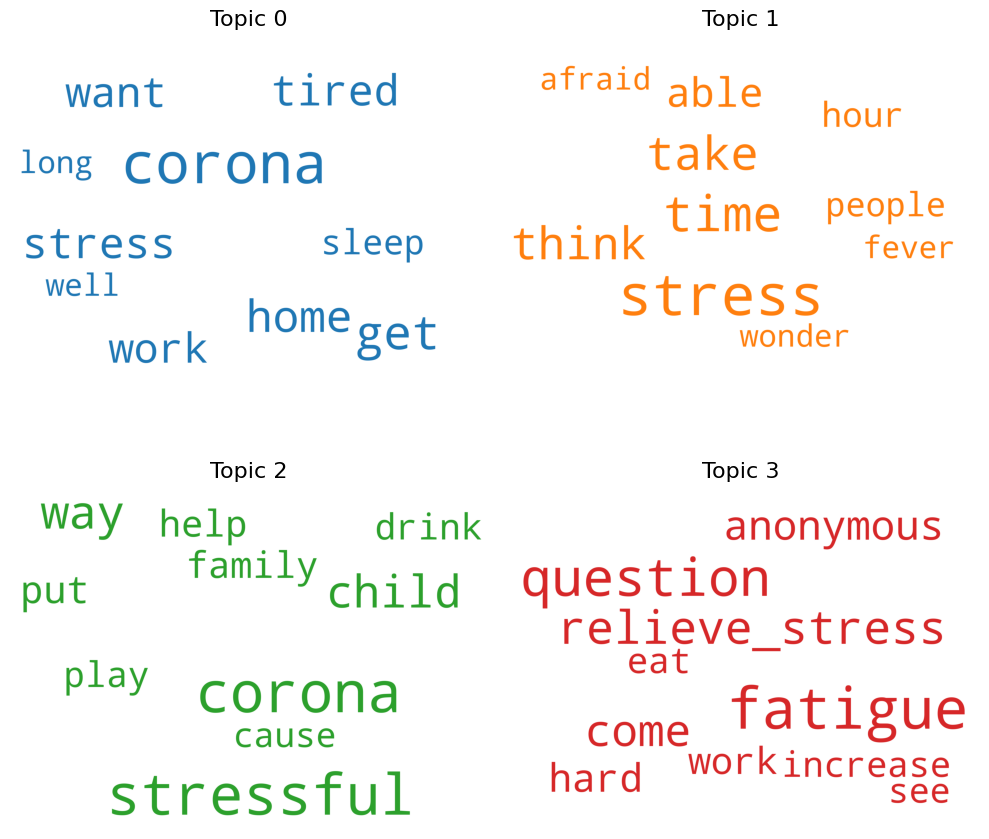

In [18]:
# Word Clouds of Top N Keywords in Each Topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [22]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

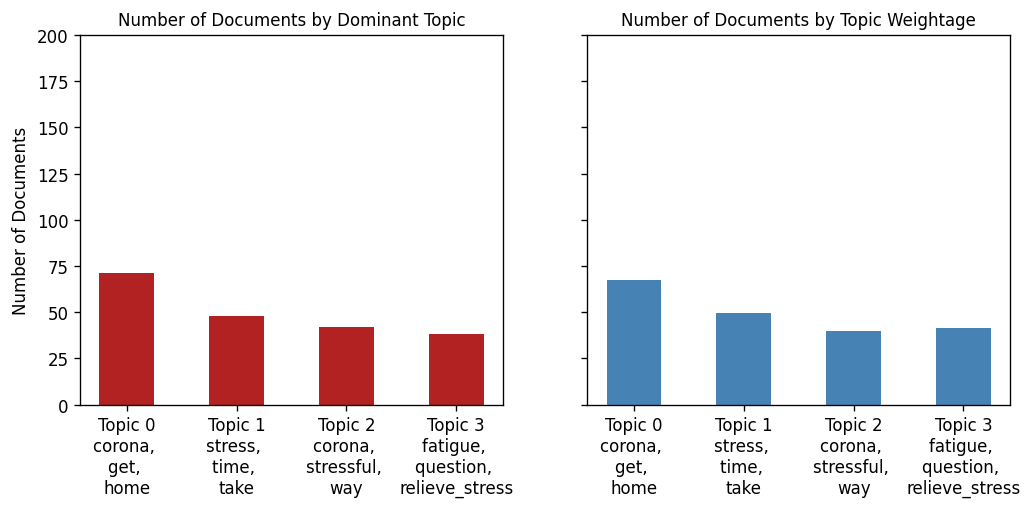

In [24]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [17]:
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"corona" + 0.031*"get" + 0.027*"home" + 0.025*"stress" + '
  '0.025*"tired" + 0.024*"want" + 0.024*"work" + 0.016*"sleep" + 0.012*"long" '
  '+ 0.012*"well"'),
 (1,
  '0.040*"stress" + 0.030*"time" + 0.026*"take" + 0.024*"think" + 0.019*"able" '
  '+ 0.013*"hour" + 0.013*"people" + 0.011*"fever" + 0.011*"afraid" + '
  '0.010*"wonder"'),
 (2,
  '0.032*"corona" + 0.032*"stressful" + 0.020*"way" + 0.019*"child" + '
  '0.013*"put" + 0.012*"help" + 0.012*"family" + 0.011*"drink" + 0.011*"play" '
  '+ 0.011*"cause"'),
 (3,
  '0.030*"fatigue" + 0.025*"question" + 0.019*"relieve_stress" + 0.018*"come" '
  '+ 0.015*"anonymous" + 0.014*"hard" + 0.012*"work" + 0.011*"eat" + '
  '0.011*"increase" + 0.011*"see"')]


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, R=30, sort_topics=False)
#vis

/Users/danmengcai/opt/anaconda3/envs/newPy/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [19]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.179491  0.049412       1        1  32.362645
1      0.021511 -0.189667       2        1  24.865891
2     -0.031153  0.137229       3        1  19.825216
3     -0.169849  0.003026       4        1  22.946248, topic_info=          Term       Freq      Total Category  logprob  loglift
29      corona  82.000000  82.000000  Default  30.0000  30.0000
87      stress  68.000000  68.000000  Default  29.0000  29.0000
155        get  38.000000  38.000000  Default  28.0000  28.0000
138  stressful  24.000000  24.000000  Default  27.0000  27.0000
36     fatigue  26.000000  26.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
846     answer   6.179659   7.552994   Topic4  -4.9397   1.2713
77        work  10.547293  41.773534   Topic4  -4.4051   0.0956
6         good   7.240607  21.785254   Topic4  -4.7813   0.3705
37        feel   7.137159  26.869056   Topic4  -4.7956   0.1464
49      people   5.868114  18.197384   Topic4  -4.9914   0.3403

[187 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
25        2  0.966420       able
173       2  0.940933     afraid
513       3  0.918610    alcohol
27        4  0.972679       also
940       4  0.972002  anonymous
...     ...       ...        ...
1131      3  0.797300      wreck
24        1  0.882459       year
24        2  0.073538       year
660       2  0.965482  yesterday
886       2  0.835541        yet

[172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

/Users/danmengcai/opt/anaconda3/envs/newPy/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danmengcai/opt/anaconda3/envs/newPy/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danmengcai/opt/anaconda3/envs/newPy/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danmengcai/opt/anaconda3/envs/newPy/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
